<a href="https://colab.research.google.com/github/Santiann/Trabalho-Final-Previs-o-de-pre-o-de-voo/blob/main/Previs%C3%A3o_de_pre%C3%A7o_de_voo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importando todas as bibliotecas necessárias
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVR
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Define o dataset e o destino do download
dataset = "shubhambathwal/flight-price-prediction"
download_path = "datasets/"

# Comando para baixar o dataset
os.system(f"kaggle datasets download -d {dataset} -p {download_path} --unzip")

print(f"Dataset baixado e extraído em: {download_path}")

Dataset baixado e extraído em: datasets/


In [ ]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Vamos ver o que há nos dados
df=pd.read_csv('/content/datasets/Clean_Dataset.csv')
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [ ]:
# Eliminando a coluna inútil 'Unnamed: 0'
df=df.drop('Unnamed: 0',axis=1)

In [ ]:
# Uma informação rápida sobre os dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [ ]:
# Descrição Estatística dos Dados
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [ ]:
# Seleciona apenas colunas numéricas
df_numeric = df.select_dtypes(include=['number'])

# Calcula a correlação e transposta
correlation_matrix = df_numeric.corr().T

print(correlation_matrix)

           duration  days_left     price
duration   1.000000  -0.039157  0.204222
days_left -0.039157   1.000000 -0.091949
price      0.204222  -0.091949  1.000000


In [ ]:
# Tamanho dos dados
df.shape

(300153, 11)

In [ ]:
df1=df.groupby(['flight','airline'],as_index=False).count()
df1.airline.value_counts()

,count
airline,
Indigo,704
Air_India,218
GO_FIRST,205
SpiceJet,186
Vistara,133
AirAsia,115


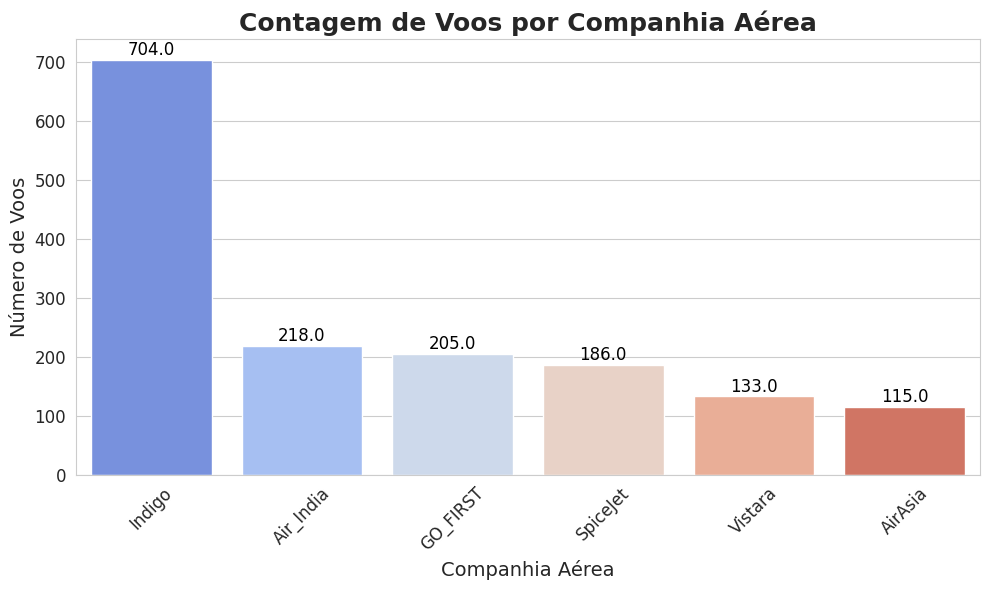

In [ ]:
# Configurando o estilo e ajustando o tamanho da figura
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Criando o gráfico com uma paleta mais vibrante
palette = sns.color_palette("coolwarm", len(df1['airline'].unique()))
ax = sns.countplot(data=df1, x='airline', palette=palette, order=df1['airline'].value_counts().index)

# Adicionando rótulos de valores nas barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 7), textcoords='offset points')

# Melhorando os títulos e rótulos
plt.title('Contagem de Voos por Companhia Aérea', fontsize=18, fontweight='bold')
plt.xlabel('Companhia Aérea', fontsize=14)
plt.ylabel('Número de Voos', fontsize=14)

# Girando os rótulos no eixo X (caso necessário)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

In [ ]:
df2=df.groupby(['flight','airline','class'],as_index=False).count()
df2['class'].value_counts()

,count
class,
Economy,1560
Business,295


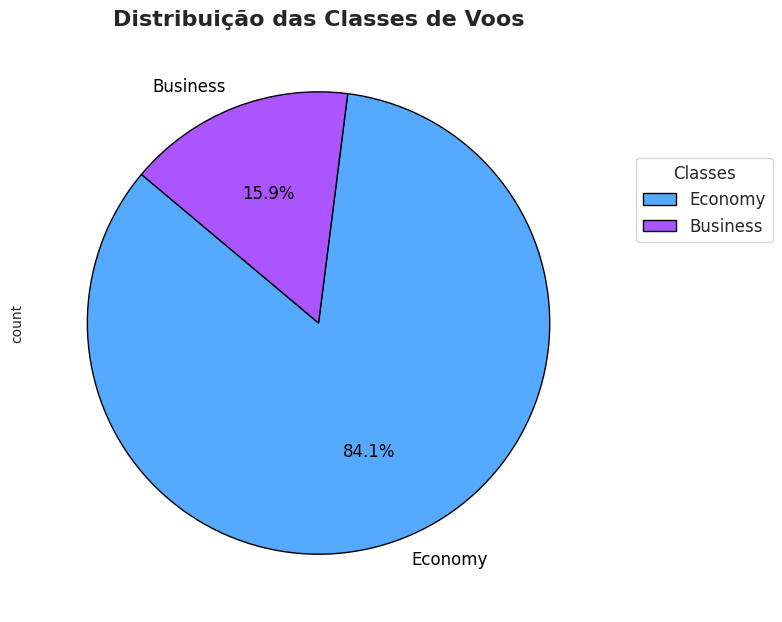

In [ ]:
# Configurando o tamanho da figura
plt.figure(figsize=(8, 8))

# Criando o gráfico de pizza com melhorias
colors = sns.color_palette("cool", len(df2['class'].unique()))  # Paleta de cores
df2['class'].value_counts().plot(
    kind='pie',
    textprops={'color': 'black', 'fontsize': 12},
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

# Adicionando título
plt.title('Distribuição das Classes de Voos', fontsize=16, fontweight='bold')

# Melhorando a legenda
plt.legend(
    labels=df2['class'].value_counts().index,
    title='Classes',
    title_fontsize=12,
    loc='upper right',
    fontsize=12,
    frameon=True,
    bbox_to_anchor=(1.3, 0.8)
)

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

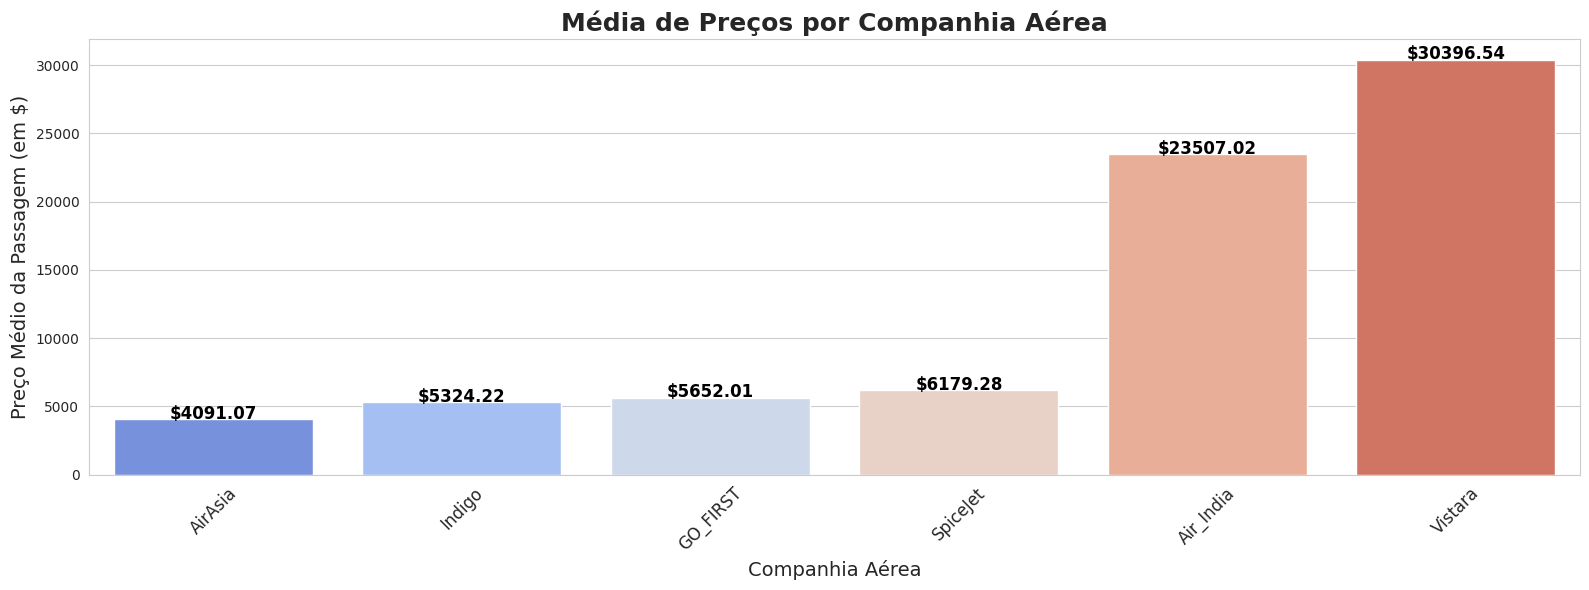

In [ ]:
# Calculando a média dos preços por companhia
mean_prices = df.groupby('airline')['price'].mean().sort_values()

# Configurando o estilo e tamanho do gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))

# Criando o gráfico de barras
sns.barplot(
    x=mean_prices.index,
    y=mean_prices.values,
    palette='coolwarm'
)

# Adicionando rótulos de valores acima das barras
for i, val in enumerate(mean_prices.values):
    plt.text(i, val + 10, f'${val:.2f}', ha='center', fontsize=12, color='black', weight='bold')

# Ajustando títulos e rótulos
plt.title('Média de Preços por Companhia Aérea', fontsize=18, fontweight='bold')
plt.xlabel('Companhia Aérea', fontsize=14)
plt.ylabel('Preço Médio da Passagem (em $)', fontsize=14)

# Ajustando rótulos do eixo X
plt.xticks(rotation=45, fontsize=12)

# Ajustando espaçamento
plt.tight_layout()

# Exibindo o gráfico
plt.show()

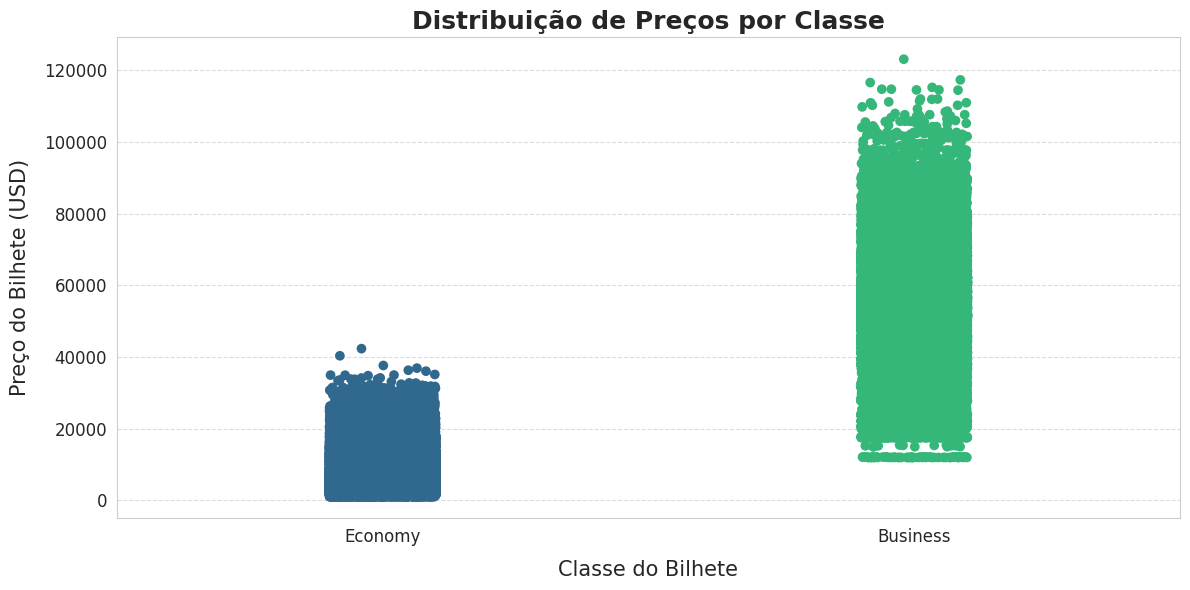

In [ ]:
# Grafico para visualizar a concentração de preços por classes
plt.figure(figsize=(12, 6))
sns.stripplot(x='class', y='price', data=df, palette='viridis', size=7, jitter=True)

# Melhorando o título e os rótulos
plt.title('Distribuição de Preços por Classe', fontsize=18, fontweight='bold')
plt.xlabel('Classe do Bilhete', fontsize=15, labelpad=10)
plt.ylabel('Preço do Bilhete (USD)', fontsize=15, labelpad=10)

# Ajustando o estilo
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

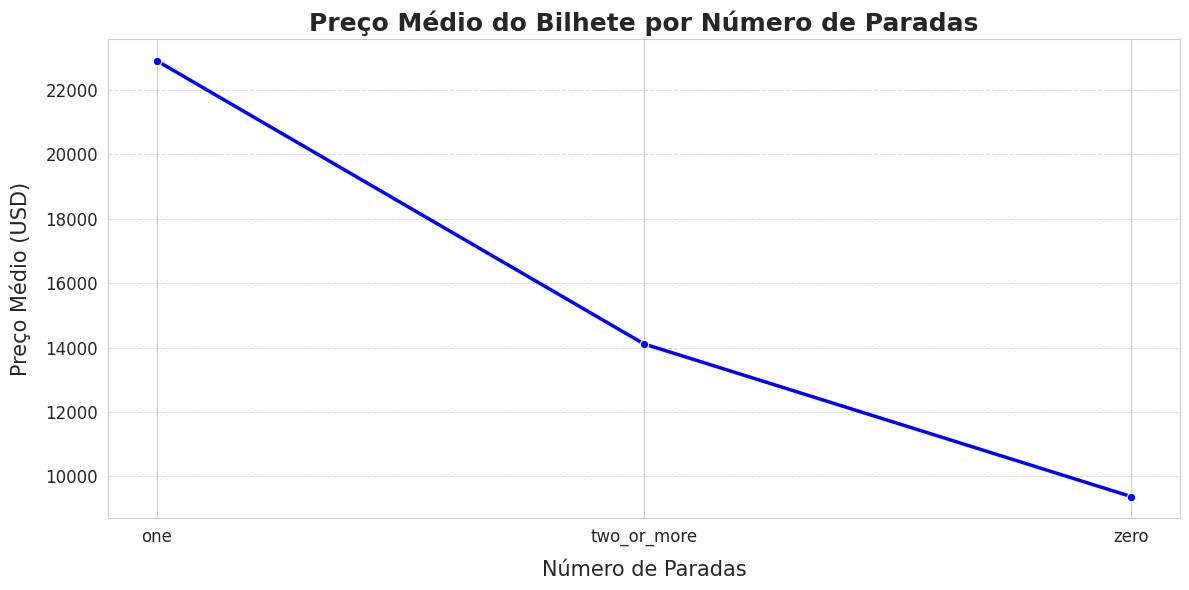

In [ ]:
# Grafico que mostra a quantidade de bilhetes vendidos por números de paradas,
# dando a entender que passagens com pelo menos 1 paradas são mais caras do que viagens sem nenhuma parada.
# Dando a entender que paradas são mais buscadas que viagens sem paradas.
plt.figure(figsize=(12, 6))

# Calculando as médias
mean_prices = df.groupby('stops')['price'].mean().reset_index()

# Gráfico de linha
sns.lineplot(x='stops', y='price', data=mean_prices, marker='o', color='blue', linewidth=2.5)

# Melhorando os rótulos e título
plt.title('Preço Médio do Bilhete por Número de Paradas', fontsize=18, fontweight='bold')
plt.xlabel('Número de Paradas', fontsize=15, labelpad=10)
plt.ylabel('Preço Médio (USD)', fontsize=15, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


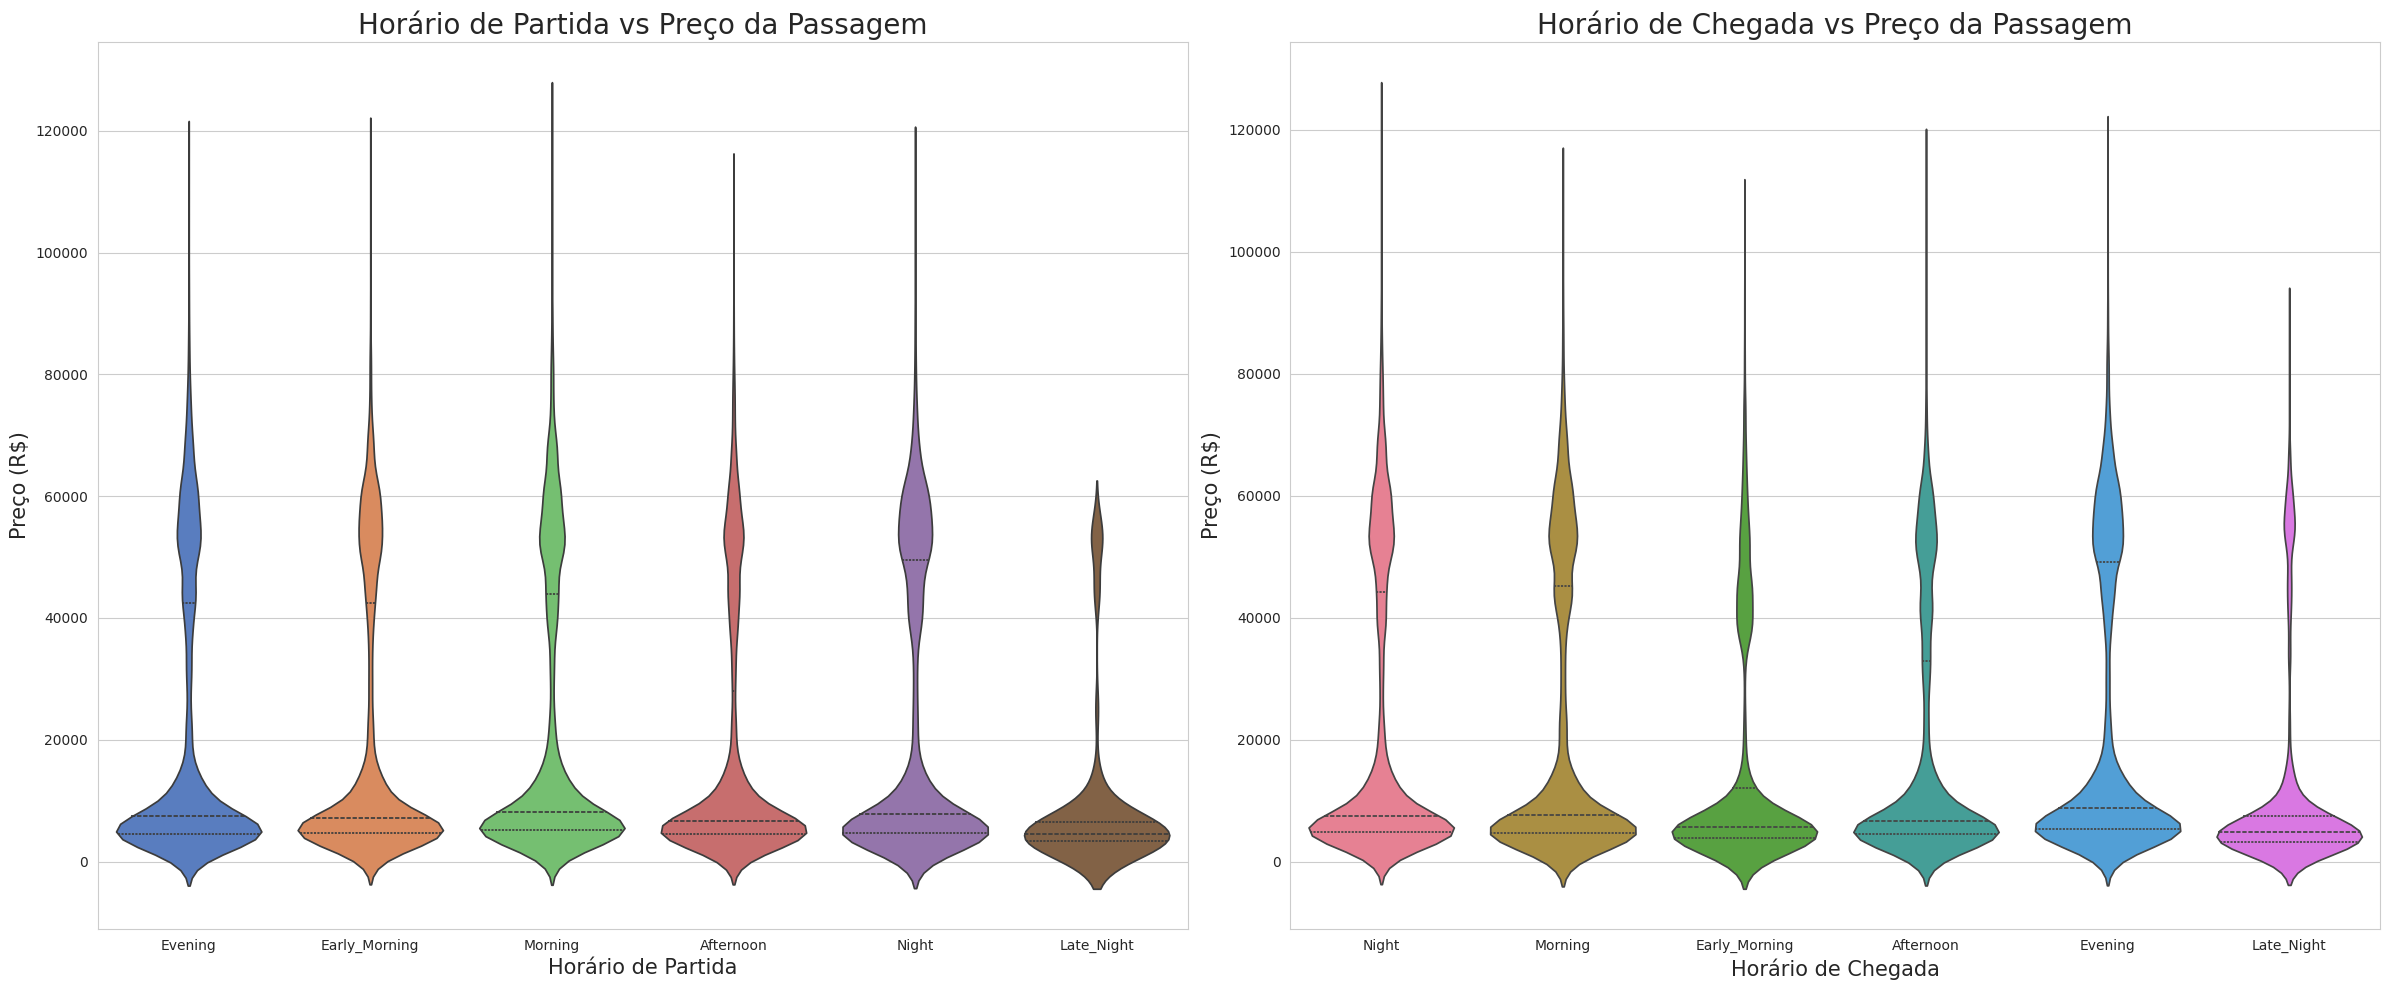

In [ ]:
plt.figure(figsize=(24, 10))

# Gráfico para Horário de Partida vs Preço da Passagem
plt.subplot(1, 2, 1)
sns.violinplot(x='departure_time', y='price', data=df, inner="quartile", scale="width", palette="muted")
plt.title('Horário de Partida vs Preço da Passagem', fontsize=20)
plt.xlabel('Horário de Partida', fontsize=15)
plt.ylabel('Preço (R$)', fontsize=15)

# Gráfico para Horário de Chegada vs Preço da Passagem
plt.subplot(1, 2, 2)
sns.violinplot(x='arrival_time', y='price', data=df, inner="quartile", scale="width", palette="husl")
plt.title('Horário de Chegada vs Preço da Passagem', fontsize=20)
plt.xlabel('Horário de Chegada', fontsize=15)
plt.ylabel('Preço (R$)', fontsize=15)

plt.tight_layout()
plt.show()

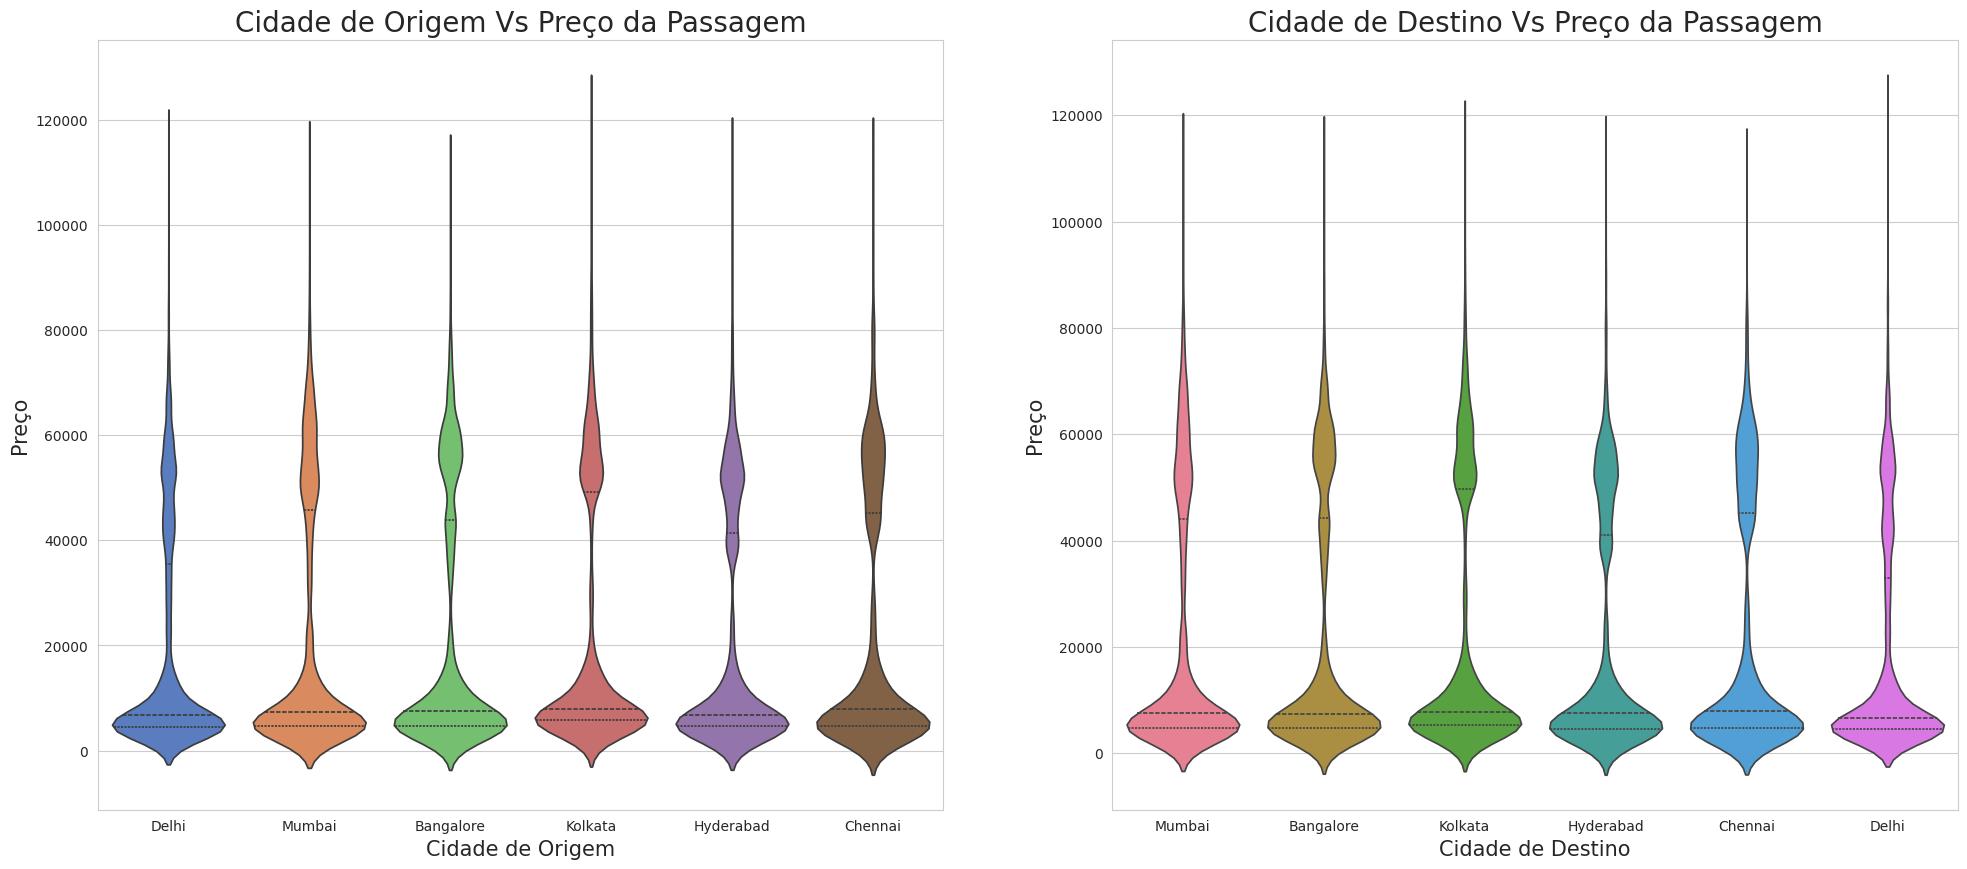

In [ ]:
plt.figure(figsize=(24,10))

# Gráfico de violino para cidade de origem
plt.subplot(1, 2, 1)
sns.violinplot(x='source_city', y='price', data=df, inner="quartile", scale="width", palette='muted')
plt.title('Cidade de Origem Vs Preço da Passagem', fontsize=20)
plt.xlabel('Cidade de Origem', fontsize=15)
plt.ylabel('Preço', fontsize=15)

# Gráfico de violino para cidade de destino
plt.subplot(1, 2, 2)
sns.violinplot(x='destination_city', y='price', data=df, inner="quartile", scale="width", palette='husl')
plt.title('Cidade de Destino Vs Preço da Passagem', fontsize=20)
plt.xlabel('Cidade de Destino', fontsize=15)
plt.ylabel('Preço', fontsize=15)

plt.show()

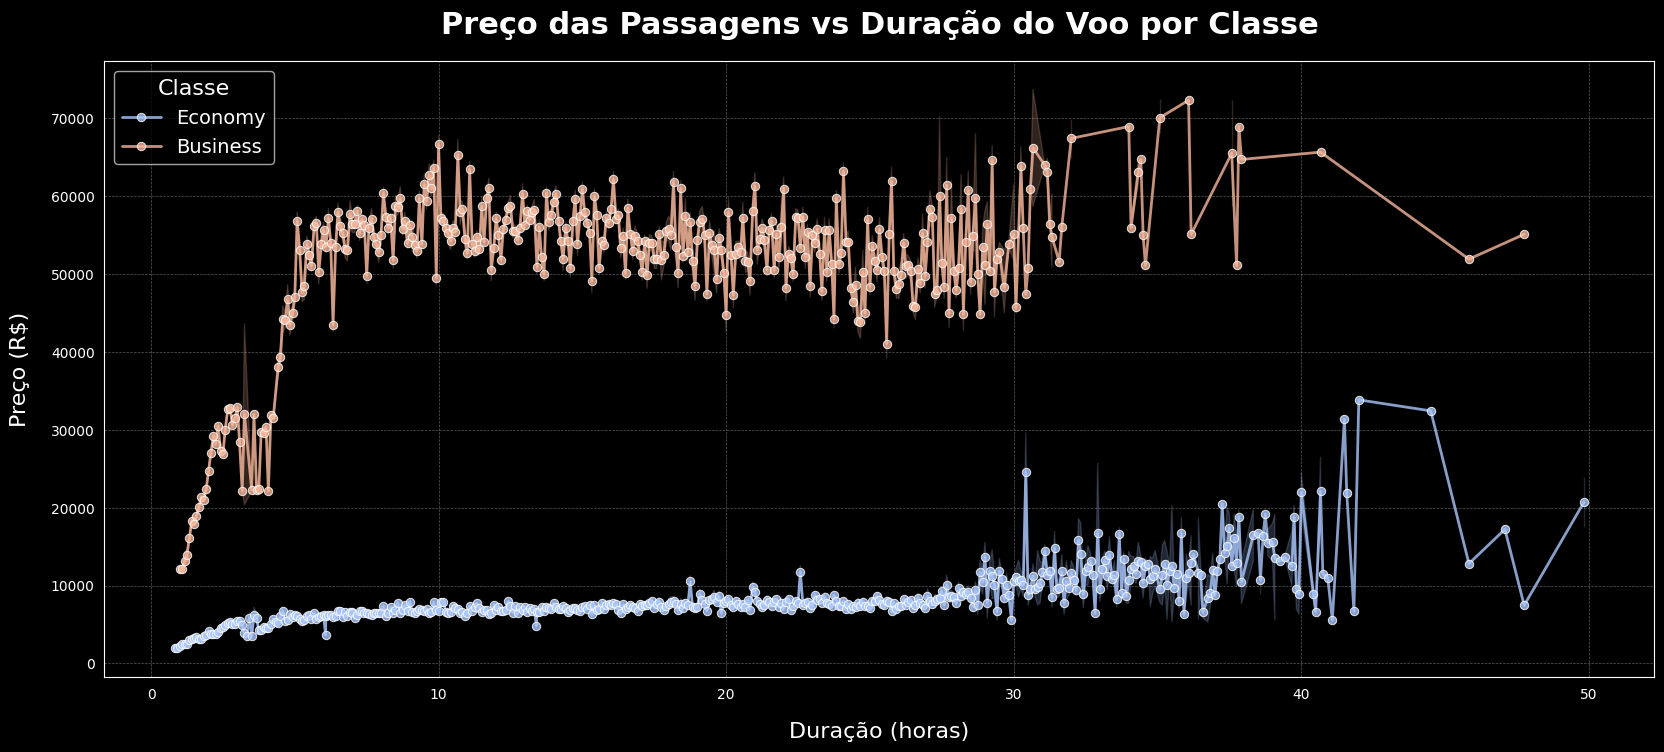

In [ ]:
# Estilo do fundo
plt.style.use('dark_background')

# Configurações da figura
plt.figure(figsize=(20, 8))

# Paleta de cores personalizada
sns.set_palette("coolwarm")

# Gráfico com linhas suaves e transparência
sns.lineplot(
    data=df,
    x='duration',
    y='price',
    hue='class',
    palette='coolwarm',
    linewidth=2,
    alpha=0.8,
    marker='o'  # Marcadores para diferenciar classes
)

# Melhorias no título e rótulos
plt.title(
    'Preço das Passagens vs Duração do Voo por Classe',
    fontsize=22,
    pad=20,  # Espaçamento
    fontweight='bold'
)
plt.xlabel('Duração (horas)', fontsize=16, labelpad=15)
plt.ylabel('Preço (R$)', fontsize=16, labelpad=15)

# Adicionar grid discreto
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Ajustar posição da legenda
plt.legend(title='Classe', fontsize=14, title_fontsize=16, loc='upper left')

# Mostrar o gráfico
plt.show()

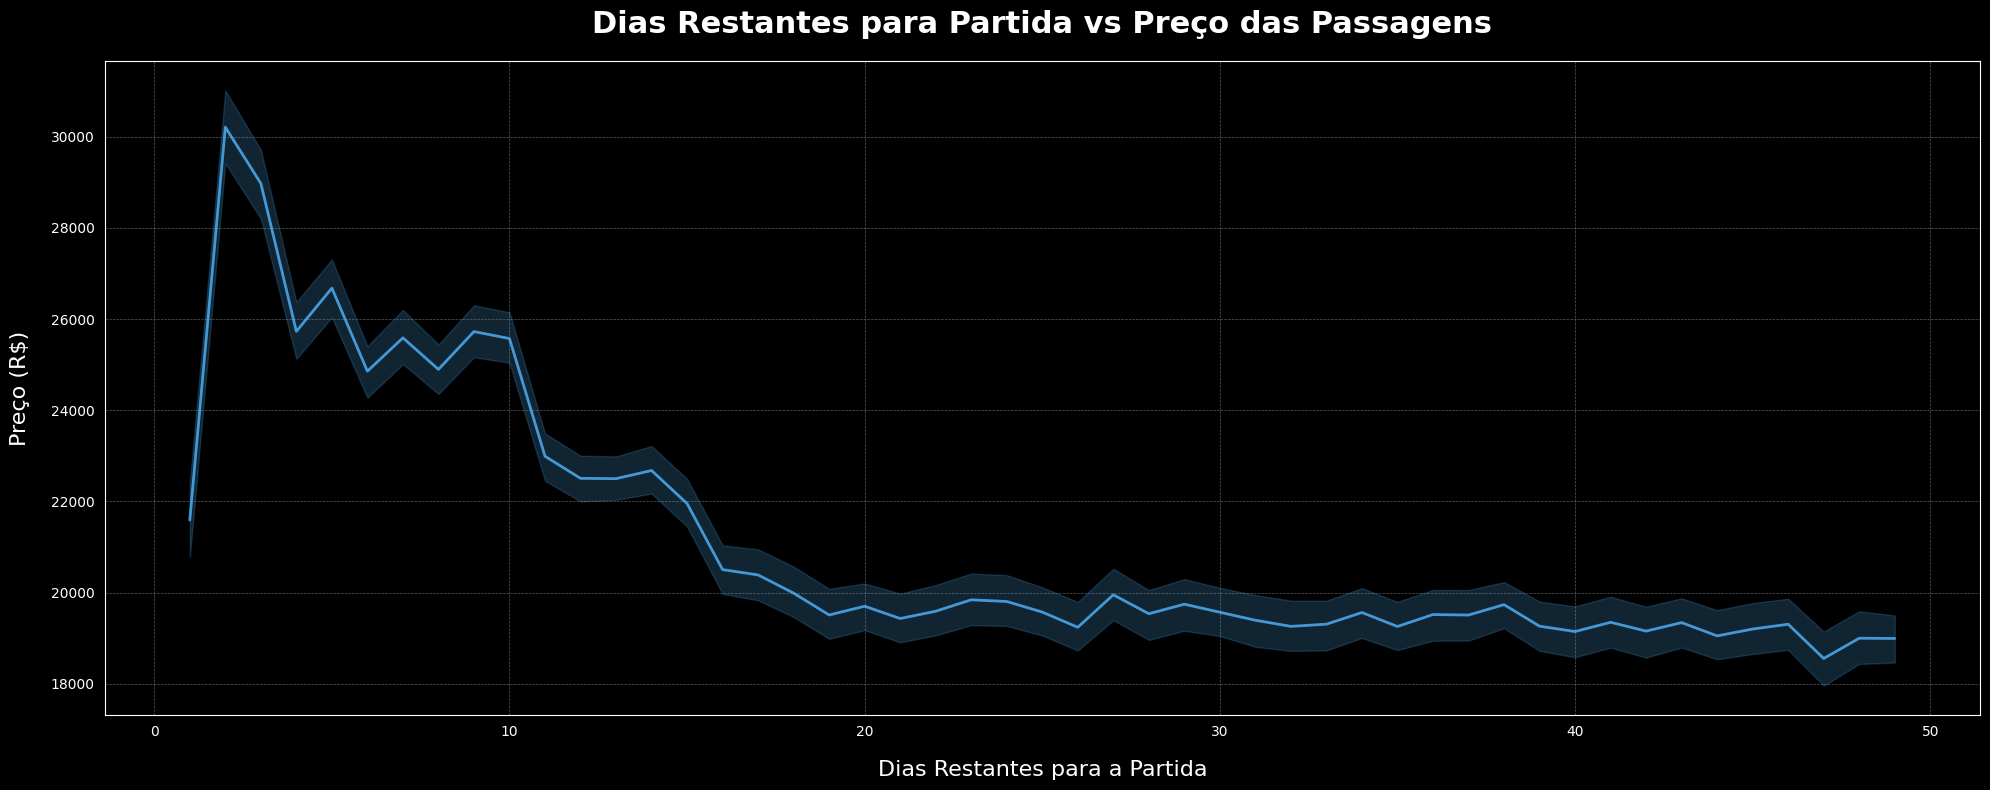

In [ ]:
# Estilo do fundo
plt.style.use('dark_background')

# Configurações da figura
plt.figure(figsize=(20, 8))

# Gráfico com linha mais visível e suavidade
sns.lineplot(
    data=df,
    x='days_left',
    y='price',
    color='#51b6ff',  # Azul mais claro e agradável
    linewidth=2,
    alpha=0.8
)

# Melhorias no título e rótulos
plt.title(
    'Dias Restantes para Partida vs Preço das Passagens',
    fontsize=22,
    pad=20,  # Espaçamento
    fontweight='bold'
)
plt.xlabel('Dias Restantes para a Partida', fontsize=16, labelpad=15)
plt.ylabel('Preço (R$)', fontsize=16, labelpad=15)

# Adicionar grade discreta
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Ajustar margens para melhor exibição
plt.tight_layout()

# Mostrar o gráfico
plt.show()


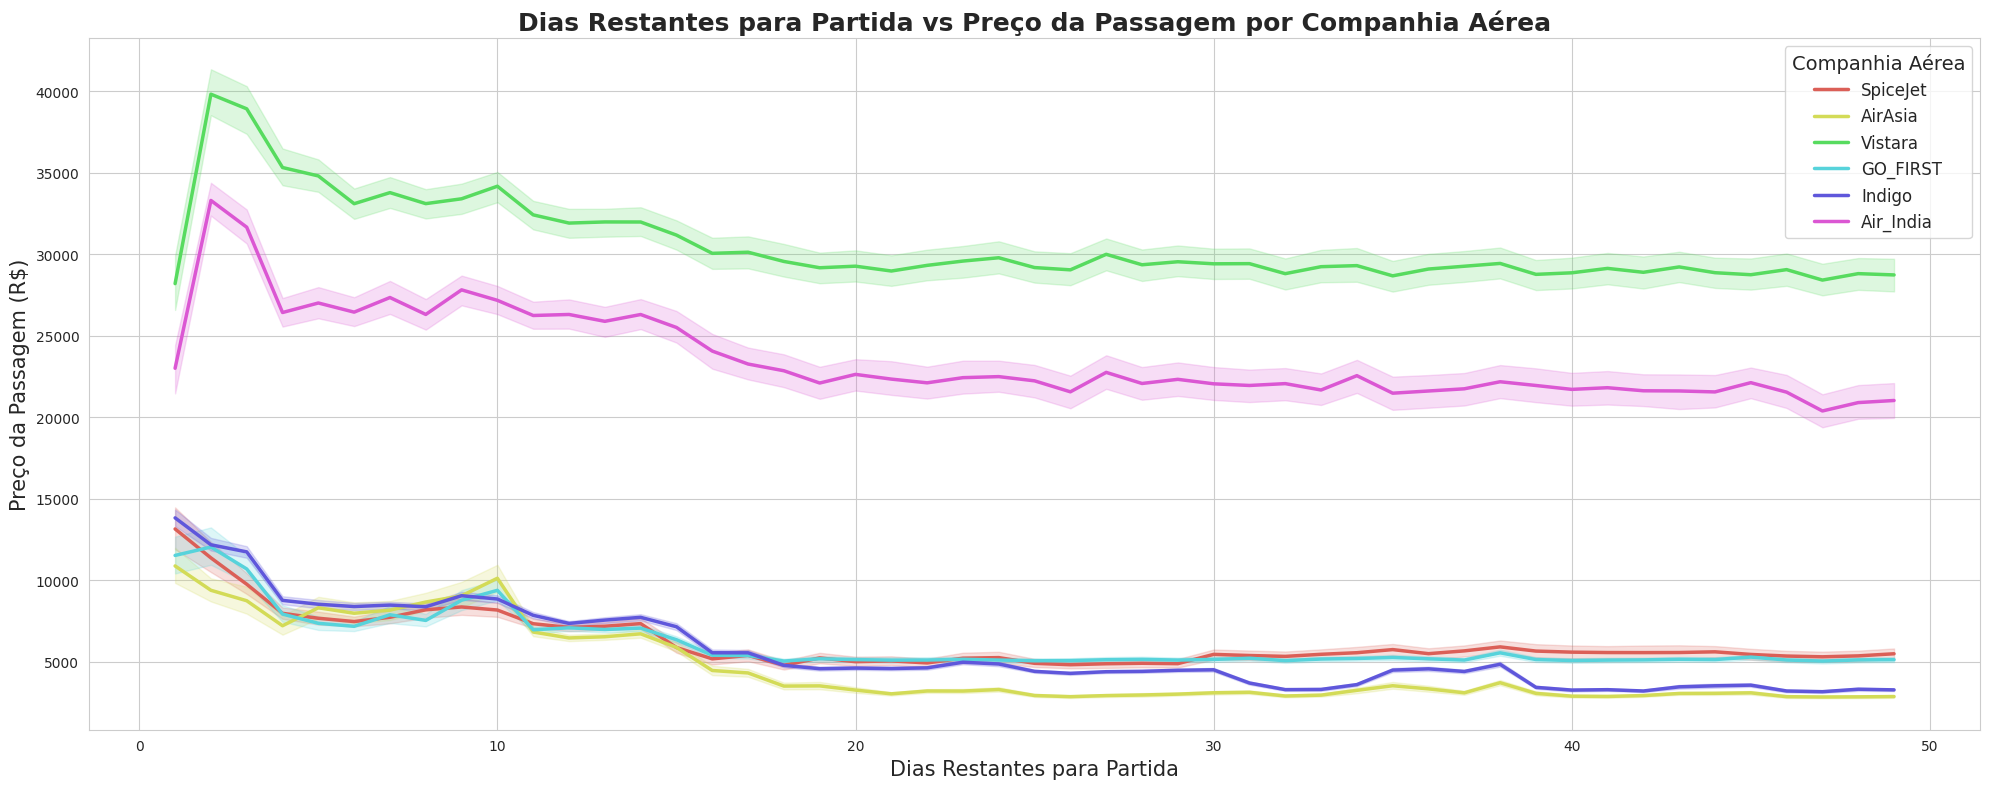

In [ ]:
# Configuração de estilo
sns.set_style("whitegrid")

plt.figure(figsize=(20, 8))

# Gráfico de linhas com paleta e legendas
sns.lineplot(
    data=df,
    x='days_left',
    y='price',
    hue='airline',
    palette='hls',
    linewidth=2.5
)

# Títulos e legendas traduzidos
plt.title('Dias Restantes para Partida vs Preço da Passagem por Companhia Aérea', fontsize=18, fontweight='bold')
plt.xlabel('Dias Restantes para Partida', fontsize=15)
plt.ylabel('Preço da Passagem (R$)', fontsize=15)

# Ajustando a legenda
plt.legend(title='Companhia Aérea', fontsize=12, title_fontsize=14, loc='upper right')

# Ajuste dos limites e exibição
plt.tight_layout()
plt.show()


In [ ]:
# Primeiro agrupamento: Agrupa o DataFrame por 'flight', 'source_city', 'destination_city', 'airline' e 'class'.
# O parâmetro 'as_index=False' garante que os grupos não sejam usados como índice no resultado.
# Conta o número de ocorrências em cada grupo criado anteriormente.
# Segundo agrupamento: Reagrupa os dados resultantes, agora por 'source_city' e 'destination_city'.
# O parâmetro 'as_index=False' novamente impede que os grupos sejam usados como índice no resultado.
# Conta o número de voos únicos ('flight') para cada combinação de 'source_city' e 'destination_city'.
# Seleciona apenas as 10 primeiras linhas do resultado.
# Quantos voos diferentes existem entre pares de cidades de origem e destino, considerando apenas as 10 primeiras combinações?

df.groupby(['flight', 'source_city', 'destination_city', 'airline', 'class'], as_index=False).count().groupby(['source_city', 'destination_city'], as_index=False)['flight'].count().head(10)

,source_city,destination_city,flight
0,Bangalore,Chennai,106
1,Bangalore,Delhi,227
2,Bangalore,Hyderabad,132
3,Bangalore,Kolkata,171
4,Bangalore,Mumbai,175
5,Chennai,Bangalore,69
6,Chennai,Delhi,105
7,Chennai,Hyderabad,82
8,Chennai,Kolkata,110
9,Chennai,Mumbai,94


In [ ]:
# Agrupa o DataFrame pelas colunas 'airline', 'source_city' e 'destination_city'.
# O parâmetro 'as_index=False' garante que os grupos não sejam usados como índice no resultado.
# Calcula a média dos preços ('price') para cada grupo definido anteriormente.
# Seleciona as 10 primeiras linhas do resultado.
# Qual é o preço médio dos voos por companhia aérea entre pares de cidades de origem e destino, considerando apenas as 10 primeiras combinações?

df.groupby(['airline', 'source_city', 'destination_city'], as_index=False)['price'].mean().head(10)

,airline,source_city,destination_city,price
0,AirAsia,Bangalore,Chennai,2073.043478
1,AirAsia,Bangalore,Delhi,4807.092426
2,AirAsia,Bangalore,Hyderabad,2931.494792
3,AirAsia,Bangalore,Kolkata,4443.468160
4,AirAsia,Bangalore,Mumbai,3342.385350
5,AirAsia,Chennai,Bangalore,1914.760870
6,AirAsia,Chennai,Delhi,3697.314003
7,AirAsia,Chennai,Hyderabad,2053.182540
8,AirAsia,Chennai,Kolkata,3682.338762
9,AirAsia,Chennai,Mumbai,2691.100000


In [ ]:
# Criando um arquivo de backup
df_bk=df.copy()

In [ ]:
# Convertendo os rótulos em um formato numérico usando o Label Encoder
# Converte colunas categórias para númericas
le=LabelEncoder()
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=le.fit_transform(df[col])

In [ ]:
# armazenando as variáveis ​​dependentes em X e a variável independente em Y
# Separação é essencial para o treinamento do modelo
x=df.drop(['price'],axis=1)
y=df['price']

In [ ]:
# Dividindo os dados em conjunto de treinamento e conjunto de teste
# Separação feita para o treinamento do modelo e para seus eventuais testes
# X = Df sem a coluna price
# Y = Df com a coluna price

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((210107, 10), (90046, 10), (210107,), (90046,))

In [ ]:
# Escalando os valores para converter os valores int para linguagens de máquina
# Normalização dos dados, define que os dados deverão estar em uma escalada de 0 a 1, podendo ser 0.5 ou 0.6.

mmscaler=MinMaxScaler(feature_range=(0,1))
x_train=mmscaler.fit_transform(x_train)
x_test=mmscaler.transform(x_test)
x_train=pd.DataFrame(x_train)
x_test=pd.DataFrame(x_test)

In [ ]:
# Cria um dataframe chamada Results

a={'Model Name':[], 'Mean_Absolute_Error_MAE':[] ,'Adj_R_Square':[] ,'Root_Mean_Squared_Error_RMSE':[] ,'Mean_Absolute_Percentage_Error_MAPE':[] ,'Mean_Squared_Error_MSE':[] ,'Root_Mean_Squared_Log_Error_RMSLE':[] ,'R2_score':[]}
Results=pd.DataFrame(a)
Results.head()

,Model Name,Mean_Absolute_Error_MAE,Adj_R_Square,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score


In [ ]:
# Crie objetos de modelos de Regressão/Regressor com hiperparâmetros padrão
# Modelos de regresão preveem valores contínuos, como o preço de passagens aéreas.
# Modelos de classificação preveem como se um cliente vai comprar ou não uma passagem.
modelmlg = LinearRegression()
modeldcr = DecisionTreeRegressor()
modelrfr = RandomForestRegressor()
modelETR = ExtraTreesRegressor()

# Matriz de avaliação para todos os algoritmos
MM = [modelmlg, modeldcr, modelrfr, modelETR]

for models in MM:

    # Ajuste o modelo com dados de trem
    models.fit(x_train, y_train)

    # Preveja o modelo com dados de teste
    y_pred = models.predict(x_test)

    # Imprime o nome do modelo
    print('Nome do Modelo: ', models)

    # Métricas de avaliação para análise de regressão
    print('Erro Absoluto Médio (MAE):', round(metrics.mean_absolute_error(y_test, y_pred),3))
    # Mede a média dos erros absolutos entre os valores reais e os valores previstos pelo modelo.
    # Exemplo: Se o preço real for R$ 300 e a previsão for R$ 320, o erro é R$ 20.
    # Um MAE menor indica previsões mais precisas.

    print('Erro Quadrático Médio (MSE):', round(metrics.mean_squared_error(y_test, y_pred),3))
    # Mede a média dos quadrados das diferenças entre os valores reais e previstos. Como eleva ao quadrado os erros, penaliza erros maiores mais severamente.
    # MSE baixo é desejado, mas é mais sensível a grandes discrepâncias.
    # É útil para identificar se há previsões muito erradas.

    print('Raiz do Erro Quadrático Médio (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
    # É a raiz quadrada do MSE. Retorna o erro médio na mesma unidade da variável prevista (neste caso, o preço das passagens).
    # Mais intuitivo que o MSE, pois mantém a unidade dos dados.
    # Também penaliza erros grandes, mas é fácil de interpretar diretamente.

    print('Coeficiente de Determinação (R²):', round(metrics.r2_score(y_test, y_pred),6))
    # Mede a proporção da variabilidade dos dados explicada pelo modelo.
    # Vai de 0 a 1, onde:
      # 0 significa que o modelo não explica nada.
      # 1 significa que o modelo explica toda a variabilidade dos dados.
    # Um R² mais alto indica um modelo melhor para explicar os dados.
    # No entanto, não considera o número de variáveis no modelo.

    print('Raiz do Erro Quadrático Médio Logarítmico (RMSLE):', round(np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),3))
    # Mede a diferença entre os logaritmos dos valores previstos e reais.
    # É útil para problemas em que os valores têm uma ampla gama de variações e é mais tolerante a erros em valores altos.
    # Um RMSLE menor indica previsões melhores.
    # Penaliza mais erros relativos em valores baixos.

    # Defina a função para calcular o MAPE - Erro Percentual Absoluto Médio
    def MAPE (y_test, y_pred):
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Avaliação do MAPE
    result = MAPE(y_test, y_pred)
    print('Erro Percentual Absoluto Médio (MAPE):', round(result, 2), '%')
    # Mede a porcentagem média de erro em relação aos valores reais.
    # É útil para avaliar o desempenho do modelo em termos percentuais, independentemente das unidades da variável.
    # Um MAPE de 10% significa que, em média, as previsões estão 10% fora dos valores reais.

    # Calcular valores de R quadrado ajustado
    r_squared = round(metrics.r2_score(y_test, y_pred),6)
    adjusted_r_squared = round(1 - (1-r_squared)*(len(y)-1)/(len(y)-x.shape[1]-1),6)
    print('R² Ajustado: ', adjusted_r_squared)
    # É uma versão ajustada do R² que penaliza o uso de muitas variáveis no modelo.
    # Útil em datasets com muitas variáveis, pois evita que modelos complexos pareçam melhores do que são.

    print('------------------------------------------------------------------------------------------------------------')

    #-------------------------------------------------------------------------------------------
    new_row = {'Model Name' : models,
               'Mean_Absolute_Error_MAE' : metrics.mean_absolute_error(y_test, y_pred),
               'Adj_R_Square' : adjusted_r_squared,
               'Root_Mean_Squared_Error_RMSE' : np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
               'Mean_Absolute_Percentage_Error_MAPE' : result,
               'Mean_Squared_Error_MSE' : metrics.mean_squared_error(y_test, y_pred),
               'Root_Mean_Squared_Log_Error_RMSLE': np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),
               'R2_score' : metrics.r2_score(y_test, y_pred)}

    Results = pd.concat([Results, pd.DataFrame([new_row])], ignore_index=True)

Model Name:  LinearRegression()
Mean Absolute Error (MAE): 4623.409
Mean Squared Error (MSE): 49062056.15
Root Mean Squared Error (RMSE): 7004.431
R2_score: 0.904672
Root Mean Squared Log Error (RMSLE): 8.854
Mean Absolute Percentage Error (MAPE): 43.66 %
Adj R Square:  0.904669
------------------------------------------------------------------------------------------------------------
Model Name:  DecisionTreeRegressor()
Mean Absolute Error (MAE): 911.168
Mean Squared Error (MSE): 8909770.419
Root Mean Squared Error (RMSE): 2984.924
R2_score: 0.982688
Root Mean Squared Log Error (RMSLE): 8.001
Mean Absolute Percentage Error (MAPE): 6.19 %
Adj R Square:  0.982687
------------------------------------------------------------------------------------------------------------
Model Name:  RandomForestRegressor()
Mean Absolute Error (MAE): 891.953
Mean Squared Error (MSE): 5657347.729
Root Mean Squared Error (RMSE): 2378.518
R2_score: 0.989008
Root Mean Squared Log Error (RMSLE): 7.774
Mean A

In [ ]:
# Exibir resultados finais
print(Results)

                                          Model Name  Mean_Absolute_Error_MAE  \
0                                 LinearRegression()              4623.408800   
1                            DecisionTreeRegressor()               911.168314   
2  (DecisionTreeRegressor(max_features=1.0, rando...               891.952968   
3  (ExtraTreeRegressor(random_state=963109017), E...               943.702617   

   Adj_R_Square  Root_Mean_Squared_Error_RMSE  \
0      0.904669                   7004.431180   
1      0.982687                   2984.923855   
2      0.989008                   2378.517969   
3      0.987347                   2551.911455   

   Mean_Absolute_Percentage_Error_MAPE  Mean_Squared_Error_MSE  \
0                            43.663631            4.906206e+07   
1                             6.187181            8.909770e+06   
2                             5.991624            5.657348e+06   
3                             6.417591            6.512252e+06   

   Root_Mean_Squa

In [ ]:
models=['LinearRegression','DecisionTreeRegressor','RandomForestRegressor','KNeighborsRegressor','ExtraTreesRegressor','GradientBoostingRegressor','XGBRegressor','BaggingRegressor','Ridge Regression','Lasso Regression']
result=pd.DataFrame({'Model_Name':models})
result['Adj_R_Square']=Results['Adj_R_Square']
result['Mean_Absolute_Error_MAE']=Results['Mean_Absolute_Error_MAE']
result['Root_Mean_Squared_Error_RMSE']=Results['Root_Mean_Squared_Error_RMSE']
result['Mean_Absolute_Percentage_Error_MAPE']=Results['Mean_Absolute_Percentage_Error_MAPE']
result['Mean_Squared_Error_MSE']=Results['Mean_Squared_Error_MSE']
result['Root_Mean_Squared_Log_Error_RMSLE']=Results['Root_Mean_Squared_Log_Error_RMSLE']
result['R2_score']=Results['R2_score']
result=result.sort_values(by='Adj_R_Square',ascending=False).reset_index(drop=True)
result

,Model_Name,Adj_R_Square,Mean_Absolute_Error_MAE,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score
0,RandomForestRegressor,0.989008,891.952968,2378.517969,5.991624,5.657348e+06,7.774233,0.989008
1,KNeighborsRegressor,0.987347,943.702617,2551.911455,6.417591,6.512252e+06,7.844598,0.987347
2,DecisionTreeRegressor,0.982687,911.168314,2984.923855,6.187181,8.909770e+06,8.001330,0.982688
3,LinearRegression,0.904669,4623.408800,7004.431180,43.663631,4.906206e+07,8.854298,0.904672
4,ExtraTreesRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GradientBoostingRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,BaggingRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Ridge Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Lasso Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Treinando o modelo com
modelETR.fit(x_train, y_train)

# Preveja o modelo com dados de teste
y_pred = modelETR.predict(x_test)

In [ ]:
out=pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
result=df_bk.merge(out,left_index=True,right_index=True)

In [ ]:
result.sample(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Price_actual,Price_pred
15508,Air_India,AI-465,Delhi,Evening,one,Evening,Bangalore,Economy,25.08,28,5504,5504,5429.68
112890,Indigo,6E-6257,Bangalore,Early_Morning,zero,Early_Morning,Hyderabad,Economy,1.17,29,1714,1714,2095.58
180628,Indigo,6E-269,Chennai,Morning,one,Evening,Delhi,Economy,6.17,3,16272,16272,12627.67
125474,Air_India,AI-573,Kolkata,Evening,one,Night,Delhi,Economy,26.33,37,8530,8530,9015.52
278281,Vistara,UK-890,Hyderabad,Evening,one,Night,Mumbai,Business,5.17,18,60410,60410,55358.35
259345,Vistara,UK-866,Bangalore,Night,one,Morning,Chennai,Business,11.17,12,44280,44280,44280.00
267839,Vistara,UK-706,Kolkata,Morning,one,Evening,Bangalore,Business,6.75,10,87629,87629,62389.20
288294,Air_India,AI-569,Chennai,Early_Morning,one,Evening,Delhi,Business,11.92,14,45185,45185,47646.71
45553,GO_FIRST,G8-7546,Mumbai,Evening,one,Late_Night,Delhi,Economy,6.83,15,5942,5942,5496.14
183210,Indigo,6E-6006,Chennai,Afternoon,one,Night,Delhi,Economy,8.00,22,4541,4541,4156.56


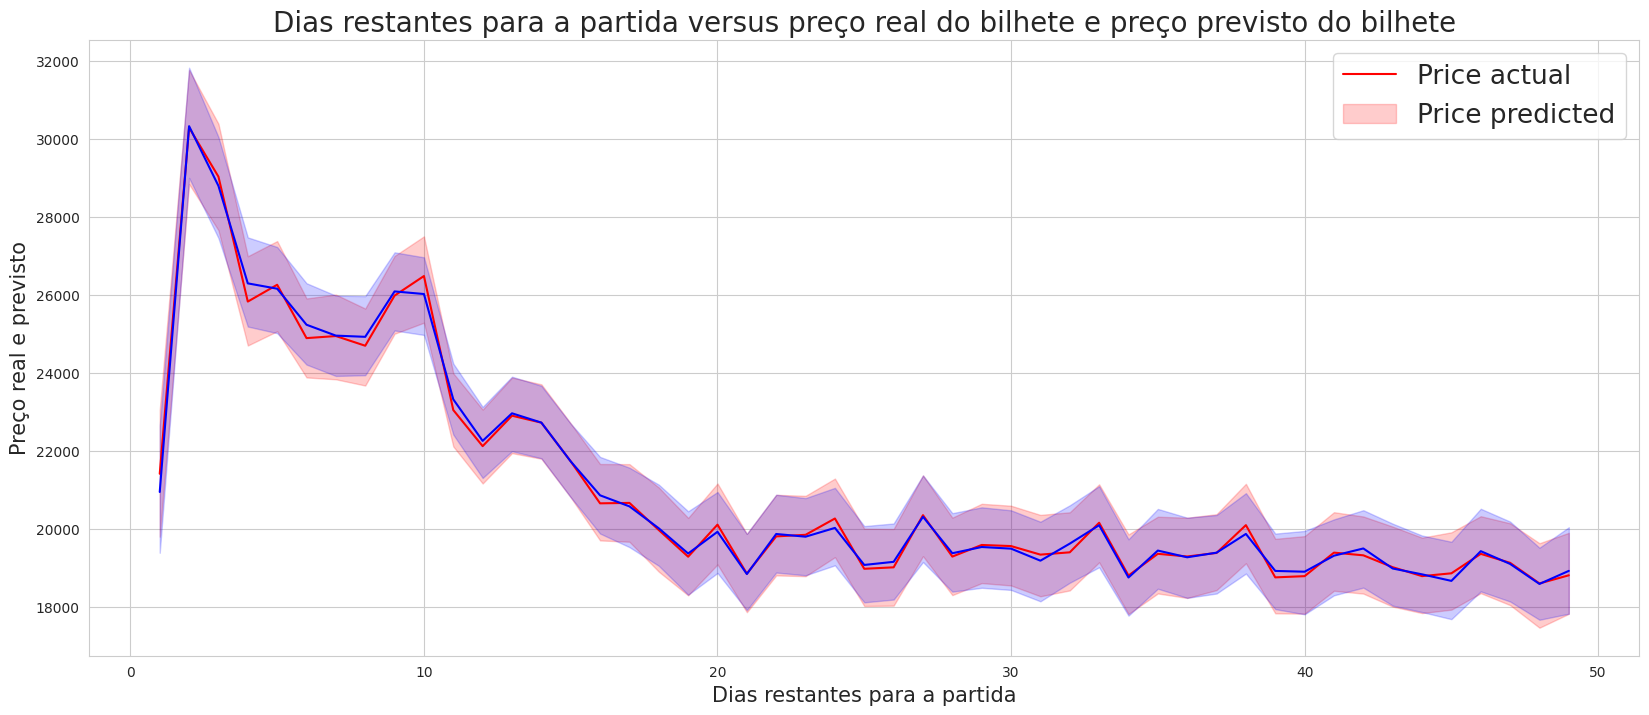

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=result,x='days_left',y='Price_actual',color='red')
sns.lineplot(data=result,x='days_left',y='Price_pred',color='blue')
plt.title('Dias restantes para a partida versus preço real do bilhete e preço previsto do bilhete',fontsize=20)
plt.legend(labels=['Price actual','Price predicted'],fontsize=19)
plt.xlabel('Dias restantes para a partida',fontsize=15)
plt.ylabel('Preço real e previsto',fontsize=15)
plt.show()

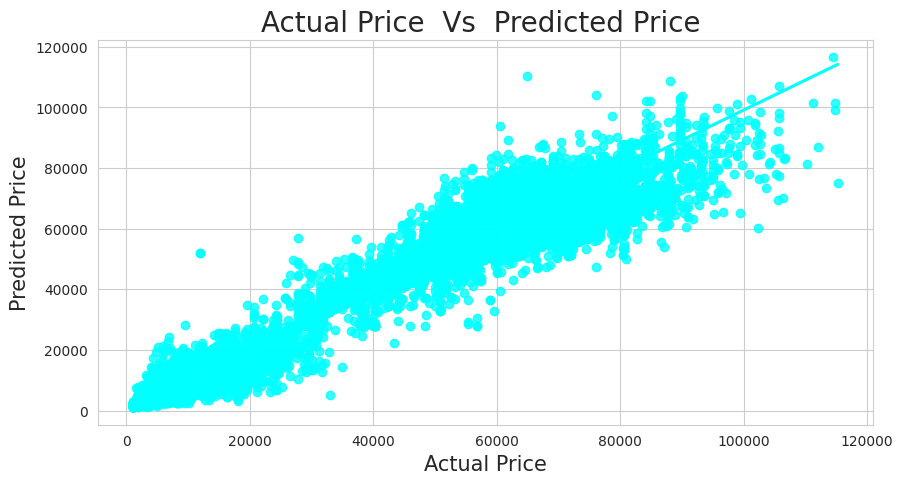

In [ ]:
plt.figure(figsize=(10,5))  # Define o tamanho do gráfico
sns.regplot(x='Price_actual', y='Price_pred', data=result, color='cyan')  # Cria um gráfico de regressão com os dados reais e previstos
plt.title('Preço Real Vs Preço Previsto', fontsize=20)  # Adiciona um título ao gráfico
plt.xlabel('Preço Real', fontsize=15)  # Define o rótulo do eixo X
plt.ylabel('Preço Previsto', fontsize=15)  # Define o rótulo do eixo Y
plt.show()  # Exibe o gráfico